**HMM Logic Sequence**

- Input: MIDI file; audio file
- Separate audio into tonal & transient responses
- Move through the score sequentially
- At each point in the score, take the block of samples
- Transition matrix: geometric distribution model of state durations
- Emission probability: tonal likelihood using GP LML
- Viterbi algorithm 'windowed' to compute most probable state sequence

In [ ]:
pip install pretty_midi pydub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 24.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.5 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=d0fa62a136a47746059b9e4340ad2d525a577c2bd98ac22f7cb7e992dfeb8474
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from pretty_midi import PrettyMIDI
import matplotlib.pyplot as plt
import pretty_midi


def load_and_filter_midi_pretty(file_path, note_range=(60, 76), remove_note=None):
    """
    Loads a MIDI file using pretty_midi, filters it to only include notes within the specified range,
    and optionally removes a specific note based on pitch and timing.

    Args:
        file_path (str): Path to the MIDI file.
        note_range (tuple): A tuple specifying the (min_note, max_note) range.
        remove_note (tuple, optional): A tuple specifying the (pitch, start_time, time_tolerance)
                                       of the note to be removed.

    Returns:
        PrettyMIDI: A new PrettyMIDI object with the filtered notes.
    """
    try:
        midi_data = pretty_midi.PrettyMIDI(file_path)

        for instrument in midi_data.instruments:
            filtered_notes = [
                note for note in instrument.notes
                if note_range[0] <= note.pitch <= note_range[1]
            ]

            if remove_note:
                pitch_to_remove, start_time, time_tolerance = remove_note
                filtered_notes = [
                    note for note in filtered_notes
                    if not (note.pitch == pitch_to_remove and
                            abs(note.start - start_time) <= time_tolerance)
                ]

            instrument.notes = filtered_notes  # Update notes

        return midi_data

    except Exception as e:
        print(f"Error loading MIDI file: {e}")
        return None



def display_midi_and_notes_pretty(midi_data):
    """
    Displays the notes of a PrettyMIDI object.

    Args:
        midi_data (PrettyMIDI): The PrettyMIDI object to analyze.

    Returns:
        list: A list of notes as tuples (start, end, pitch).
    """
    try:
        notes = []
        for instrument in midi_data.instruments:
            for note in instrument.notes:
                notes.append((note.start, note.end, note.pitch))

        # Sort notes by start time
        notes = sorted(notes, key=lambda x: x[0])

        def midi_to_note_name(midi_number):
            """Converts a MIDI note number to a piano note name."""
            note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
            octave = (midi_number // 12) - 1
            note = note_names[midi_number % 12]
            return f"{note}{octave}"

        # Print and display note names
        note_names = [(start, end, midi_to_note_name(pitch)) for start, end, pitch in notes]
        print("\nParsed Notes (start, end, pitch):")
        for note in note_names:
            print(note)

        return notes

    except Exception as e:
        print(f"Error displaying MIDI notes: {e}")
        return []


def plot_midi_piano_roll_pretty(midi_data):
    """
    Plots a piano roll visualization of a PrettyMIDI object.

    Args:
        midi_data (PrettyMIDI): The PrettyMIDI object to visualize.
    """
    try:
        notes = []
        times = []

        for instrument in midi_data.instruments:
            for note in instrument.notes:
                notes.append(note.pitch)
                times.append(note.start)

        # Plot the piano roll
        plt.figure(figsize=(10, 6))
        plt.scatter(times, notes, marker='o', color='blue', alpha=0.7)
        plt.xlabel("Time (seconds)")
        plt.ylabel("MIDI Note Number")
        plt.title("MIDI Piano Roll Visualization (PrettyMIDI)")
        plt.yticks(range(min(notes), max(notes) + 1, 2))  # Display every 2 notes
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

    except Exception as e:
        print(f"Error plotting piano roll: {e}")


Mounted at /content/drive


In [ ]:
note_to_remove = (71, 8.7, 0.1)  # Example: Remove note 70 around 8s with 0.2s tolerance
midi = load_and_filter_midi_pretty('/content/drive/MyDrive/furelise.mid', remove_note=note_to_remove)
plot_midi_piano_roll_pretty(midi)

In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')
import mido

def load_and_filter_midi(file_path, note_range=(59, 73)):
    """
    Loads a MIDI file and filters it to only contain notes within a given range,
    while maintaining timing consistency.

    Args:
        file_path (str): Path to the MIDI file.
        note_range (tuple): A tuple specifying the (min_note, max_note) range.

    Returns:
        mido.MidiFile: A new filtered MIDI file object.
    """
    try:
        # Load the original MIDI file
        midi_file = mido.MidiFile(file_path)
        filtered_midi = mido.MidiFile(ticks_per_beat=midi_file.ticks_per_beat)

        for track in midi_file.tracks:
            filtered_track = mido.MidiTrack()
            filtered_midi.tracks.append(filtered_track)

            cumulative_time = 0  # Accumulate time for consistency

            for msg in track:
                cumulative_time += msg.time  # Add the delay since the last event

                if msg.type in ['note_on', 'note_off']:
                    if note_range[0] <= msg.note <= note_range[1]:
                        # Add the event with the adjusted time
                        filtered_track.append(msg.copy(time=cumulative_time))
                        cumulative_time = 0  # Reset cumulative time after appending
                else:
                    # Add non-note messages (tempo changes, etc.) unchanged
                    filtered_track.append(msg)

            # Add any remaining time to the track
            if cumulative_time > 0:
                filtered_track.append(mido.Message('note_off', time=cumulative_time))

        return filtered_midi

    except Exception as e:
        print(f"Error loading MIDI file: {e}")
        return None


def display_midi_and_notes(midi_file):
    """Displays the contents of a MIDI file and extracts a list of played notes."""
    try:
        notes = []

        for i, track in enumerate(midi_file.tracks):
            print(f"Track {i}: {track.name}")
            for msg in track:
                print(msg)
                if msg.type == 'note_on' and msg.velocity > 0:  # Ignore note_off
                    notes.append(msg.note)

        def midi_to_note(midi_number):
            """Converts a MIDI note number to a piano note name."""
            note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
            octave = (midi_number // 12) - 1  # MIDI 0-11 is octave -1
            note = note_names[midi_number % 12]
            return f"{note}{octave}"

        note_names = [midi_to_note(i) for i in notes]

        print("\nList of MIDI Note Numbers:", notes)
        print("List of Piano Notes:", note_names)

        return notes, note_names  # Return both raw numbers and note names

    except Exception as e:
        print(f"Error reading MIDI file: {e}")
        return None, None


def plot_midi_piano_roll(midi_file):
    """Plots a MIDI piano roll visualization while preserving the original timing."""

    notes = []
    times = []
    current_time = 0  # Cumulative time in ticks

    # Iterate through all tracks
    for track in midi_file.tracks:
        for msg in track:
            if msg.type in ['note_on', 'note_off']:
                current_time += msg.time  # Add the delay since the last event
                if msg.type == 'note_on' and msg.velocity > 0:  # Only note-on messages
                    notes.append(msg.note)
                    times.append(current_time)

    # Convert MIDI ticks to seconds
    ticks_per_beat = midi_file.ticks_per_beat  # Standard resolution of the file
    tempo = 500000  # Default tempo: 500,000 microseconds per beat (120 BPM)
    for msg in midi_file.tracks[0]:  # Look for a tempo change in the first track
        if msg.type == 'set_tempo':
            tempo = msg.tempo  # Use the specified tempo if found

    # Calculate tick-to-second conversion factor
    tick_to_sec = (tempo / 1_000_000) / ticks_per_beat
    times_sec = [time * tick_to_sec for time in times]  # Convert times to seconds

    # Plot the piano roll
    plt.figure(figsize=(10, 6))
    plt.scatter(times_sec, notes, marker='o', color='blue', alpha=0.7)
    plt.xlabel("Time (seconds)")
    plt.ylabel("MIDI Note Number")
    plt.title("MIDI Piano Roll Visualization (Original Timing Preserved)")
    plt.yticks(range(min(notes), max(notes) + 1, 2))  # Display every 2 notes
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Example usage
full = mido.MidiFile('/content/drive/MyDrive/cmajorscale.mid')
# print(full)
midi = load_and_filter_midi('/content/drive/MyDrive/cmajorscale.mid')
# display_midi_and_notes(midi)
plot_midi_piano_roll(midi)
# plot_midi_piano_roll(full)


In [ ]:
# @title
import numpy as np
from scipy.stats import geom
import librosa
import pretty_midi
from scipy.ndimage import median_filter
from pydub import AudioSegment
import librosa
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from IPython.display import Audio
from scipy.io import wavfile
from scipy.fft import fft, ifft
from scipy.signal.windows import hamming, hann
from scipy.linalg import cho_factor, cho_solve




audio = AudioSegment.from_file('/content/drive/MyDrive/cmajorscale.mp3')
sample_rate = audio.frame_rate
audio_data = np.array(audio.get_array_of_samples())

time_window_size = 2048
hop_size = int(time_window_size * 0.5)
hmm_hop_size = 5000
window_size = 19
alpha = 0.4
sigma_p2 = 1e1 # Transient noise

sigma_f2 = 2e-5  # Decay parameter for covariance
sigma_n2 = 3  # Noise variance
wq = [1.0]  # Weights for fundamentals
M = 9  # Number of harmonics

sample_rate = 44100

T = 0.5
v = 2.37




def parse_midi(midi_data):    #✅
    notes = []
    for instrument in midi_data.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                notes.append((note.start, note.end, note.pitch))
    notes = sorted(notes, key=lambda x: x[0])
    print(notes)
    return notes


def compute_transition_matrices(E_Z_list, block_size=2048):
    """
    Compute a single left-to-right transition matrix for the entire score.
    Each state corresponds to a score event (note/chord) from the MIDI file.

    We first compute the average note duration (in samples) from E_Z_list
    and then convert it to the average number of blocks (of size 'block_size').
    For an average of d_avg blocks per note, a simple duration model is:

        self-transition probability:   p = 1 - 1/d_avg
        transition to next state:       1 - p

    The resulting matrix is of size (n_states x n_states) where n_states is
    the number of MIDI events.
    """
    n_states = len(E_Z_list)
    avg_duration_samples = np.mean(E_Z_list)
    d_avg = avg_duration_samples / block_size

    p = 1 - 1/d_avg if d_avg > 1 else 0.0

    T = np.zeros((n_states, n_states))
    for i in range(n_states):
        T[i, i] = p
        if i < n_states - 1:
            T[i, i+1] = 1 - p

    T[n_states-1, n_states-1] = 1
    return T


    # Possibility of having separate transient and tonal states for each note?


def extract_features():   #✅
    audio = AudioSegment.from_file('/content/drive/MyDrive/cmajorscale.mp3')
    sample_rate = audio.frame_rate
    samples = np.array(audio.get_array_of_samples())

    if audio.channels > 1:   # If the audio is stereo, reshape and convert to mono
        samples = samples.reshape((-1, audio.channels))
        audio_data = samples.mean(axis=1)
    else:
        audio_data = samples

    time_hamming_window = hann(time_window_size)
    randomized_phase = np.random.uniform(-np.pi, np.pi, time_window_size)
    processed_audio = np.zeros(len(audio_data))
    transient_probabilities = []

    time_hamming_window = hann(time_window_size)
    randomized_phase = np.random.uniform(-np.pi, np.pi, time_window_size)

    processed_audio = np.zeros(len(audio_data))

    for start in range(0, len(audio_data) - time_window_size, hop_size):
        segment = audio_data[start:start + time_window_size].astype(np.float64)
        segment *= time_hamming_window

        segment_ft = fft(segment)
        magnitude = np.abs(segment_ft)
        phase = np.angle(segment_ft)

        median_magnitude = alpha * median_filter(magnitude, size=(window_size,))
        filtered_magnitude = np.minimum(median_magnitude, magnitude)

        filtered_segment_ft = filtered_magnitude * np.exp(1j * phase)
        filtered_segment = ifft(filtered_segment_ft).real

        processed_audio[start:start + time_window_size] += filtered_segment * time_hamming_window

    processed_audio = np.int16(processed_audio / np.max(np.abs(processed_audio)) * 32767)

    tonal_audio = audio_data - processed_audio
    tonal_audio = np.int16(tonal_audio / np.max(np.abs(tonal_audio)) * 32767)

    return tonal_audio, processed_audio


def harmonic_weight(m, T, v):   #✅
    return 1 / (1 + T * m**v)


def covariance_function(tau, wq, midi_frequencies, T, v):
    cov = np.exp(-2 * np.pi**2 * sigma_f2 * tau**2)
    for fq in midi_frequencies:
        harmonic_sum = 0
        for m in range(1, M + 1):
            E_m = harmonic_weight(m, T, v)
            harmonic_sum += E_m * np.cos(2 * np.pi * m * fq * tau)
        cov += wq[0] * harmonic_sum
    return cov


def compute_covariance_matrix(midi_frequencies, block_size, sample_rate, T, v):
    t = np.linspace(0, block_size / sample_rate, block_size)
    tau = t[:, None] - t[None, :]

    cov = np.exp(-2 * np.pi**2 * sigma_f2 * tau**2)

    harmonic_weights = np.array([harmonic_weight(m, T, v) for m in range(1, M + 1)])
    harmonic_weights = harmonic_weights[:, None, None]

    for fq in midi_frequencies:
        harmonic_matrix = harmonic_weights * np.cos(2 * np.pi * np.arange(1, M + 1)[:, None, None] * fq * tau)
        cov += np.sum(harmonic_matrix, axis=0)

    return cov


def tonal_LML(y, K, sigma_n2):
    N = len(y)
    K_noise = K + sigma_n2 * np.eye(N)
    cho_decomp = cho_factor(K_noise, lower=True)
    alpha = cho_solve(cho_decomp, y)
    log_det = 2 * np.sum(np.log(np.diag(cho_decomp[0])))
    LML = (
        -0.5 * np.dot(y.T, alpha)
        - 0.5 * log_det
        - 0.5 * N * np.log(2 * np.pi)
    )
    return LML


def compute_emission_probabilities(tonal_audio, sample_rate, midi_notes,
                                   block_size=2048, hmm_hop_size=5000,
                                   T_val=T, v_val=v, sigma_n2_val=sigma_n2):
    """
    For each observation block of the tonal audio, compute an emission log–likelihood
    vector (one per state) only for states whose corresponding MIDI note has already started.
    For states beyond the allowed one, assign a log–likelihood of -∞.
    """
    n_states = len(midi_notes)
    midi_starts = [note[0] for note in midi_notes]

    base_frequencies = []
    for note in midi_notes:
        _, _, pitch = note
        base_frequency = 440.0 * 2 ** ((pitch - 69) / 12.0)
        base_frequencies.append(base_frequency)

    n_obs = (len(tonal_audio) - block_size) // hmm_hop_size + 1
    emissions = []
    allowed_max_states = []  # one allowed index per observation

    # Process each block.
    for obs_idx, start in enumerate(range(0, len(tonal_audio) - block_size, hmm_hop_size)):
        block = tonal_audio[start:start + block_size]
        emission_vector = np.full(n_states, -np.inf)

        current_time = start / sample_rate
        allowed_idx = np.searchsorted(midi_starts, current_time, side='right') - 1
        allowed_idx = max(allowed_idx, 0)
        allowed_max_states.append(allowed_idx)

        for i in range(allowed_idx + 1):
            candidate_frequency = base_frequencies[i]
            K = compute_covariance_matrix([candidate_frequency], block_size, sample_rate, T_val, v_val)
            log_likelihood = tonal_LML(block, K, sigma_n2_val)
            emission_vector[i] = log_likelihood

        print(f"Block start sample {start} (time {current_time:.2f}s): allowed max state = {allowed_idx}")
        print(emission_vector)
        emissions.append(emission_vector)

    return np.array(emissions), np.array(allowed_max_states)




def viterbi(transition_matrix, emissions, allowed_max_states):
    """
    Modified Viterbi algorithm that, at each observation time t, only allows states
    up to allowed_max_states[t]. That is, for each time step the algorithm
    does not even consider transitions to states beyond the current allowed maximum.
    """
    n_obs, n_states = emissions.shape
    # dp[t, i] holds the log probability of the most likely path ending in state i at time t.
    dp = np.full((n_obs, n_states), -np.inf)
    backpointer = np.zeros((n_obs, n_states), dtype=int)

    for j in range(n_states):
        if j <= allowed_max_states[0]:
            dp[0, j] = emissions[0, j]

    for t in range(1, n_obs):
        for j in range(n_states):
            if j > allowed_max_states[t]:
                dp[t, j] = -np.inf
                continue

            max_prob = -np.inf
            best_state = 0

            for i in range(n_states):
                if dp[t - 1, i] == -np.inf:
                    continue
                if transition_matrix[i, j] > 0:
                    prob = dp[t - 1, i] + np.log(transition_matrix[i, j])
                else:
                    prob = -np.inf
                if prob > max_prob:
                    max_prob = prob
                    best_state = i
            dp[t, j] = max_prob + emissions[t, j]
            backpointer[t, j] = best_state

    best_last_state = np.argmax(dp[-1])
    state_sequence = np.zeros(n_obs, dtype=int)
    state_sequence[-1] = best_last_state
    for t in range(n_obs - 1, 0, -1):
        state_sequence[t - 1] = backpointer[t, state_sequence[t]]
    return state_sequence.tolist()


def main(midi_file):
    """
    Main function to run the score follower.

    1. Parse the MIDI score.
    2. Extract tonal and transient features from the audio.
    3. Compute a left-to-right transition matrix based on note durations.
    4. Compute emission probabilities only for states (notes) that have already started.
    5. Run the modified Viterbi algorithm.
    """
    midi_notes = parse_midi(midi_file)

    tonal, transient = extract_features()

    sample_rate = 44100

    E_Z_list = [int((note[1] - note[0]) * sample_rate) for note in midi_notes]

    transition_matrix = compute_transition_matrices(E_Z_list, block_size=2048)

    emissions, allowed_max_states = compute_emission_probabilities(
        tonal, sample_rate, midi_notes,
        block_size=2048, hmm_hop_size=5000,
        T_val=T, v_val=v, sigma_n2_val=sigma_n2
    )

    state_sequence = viterbi(transition_matrix, emissions, allowed_max_states)

    print("Most probable state sequence:", state_sequence)
    return state_sequence




# Run the HMM
midi_notes = parse_midi(midi)
viterbi_output = main(midi)




In [ ]:
import numpy as np
from scipy.stats import geom
import librosa
import pretty_midi
from scipy.ndimage import median_filter
from pydub import AudioSegment
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from IPython.display import Audio
from scipy.io import wavfile
from scipy.fft import fft, ifft
from scipy.signal.windows import hann
from scipy.linalg import cho_factor, cho_solve

# Global parameters
time_window_size = 2048
hop_size = int(time_window_size * 0.5)
hmm_hop_size = 3000
window_size = 19
alpha = 0.4
eta = 1e-4
sigma_p2 = 1e1  # Transient noise

sigma_f2 = 2e-5  # Decay parameter for covariance
sigma_n2 = 3     # Noise variance
wq = [1.0]       # Weights for fundamentals
M = 9           # Number of harmonics

sample_rate = 44100
T = 0.5
v = 2.37

def parse_midi(midi_data):    #✅
    notes = []
    for instrument in midi_data.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                notes.append((note.start, note.end, note.pitch))
    notes = sorted(notes, key=lambda x: x[0])
    print(notes)
    return notes

def compute_transition_matrices(E_Z_list, block_size=2048):
    n_states = len(E_Z_list)
    avg_duration_samples = np.mean(E_Z_list)
    d_avg = avg_duration_samples / block_size
    p = 1 - 1/d_avg if d_avg > 1 else 0.0
    T = np.zeros((n_states, n_states))
    for i in range(n_states):
        T[i, i] = p
        if i < n_states - 1:
            T[i, i+1] = 1 - p
    T[n_states-1, n_states-1] = 1
    return T

def extract_features():   #✅
    audio = AudioSegment.from_file('/content/drive/MyDrive/furelise.mp3')
    sample_rate = audio.frame_rate
    samples = np.array(audio.get_array_of_samples())
    if audio.channels > 1:
        samples = samples.reshape((-1, audio.channels))
        audio_data = samples.mean(axis=1)
    else:
        audio_data = samples
    time_hamming_window = hann(time_window_size)
    processed_audio = np.zeros(len(audio_data))
    for start in range(0, len(audio_data) - time_window_size, hop_size):
        segment = audio_data[start:start + time_window_size].astype(np.float64)
        segment *= time_hamming_window
        segment_ft = fft(segment)
        magnitude = np.abs(segment_ft)
        phase = np.angle(segment_ft)
        median_magnitude = alpha * median_filter(magnitude, size=(window_size,))
        filtered_magnitude = np.minimum(median_magnitude, magnitude)
        filtered_segment_ft = filtered_magnitude * np.exp(1j * phase)
        filtered_segment = ifft(filtered_segment_ft).real
        processed_audio[start:start + time_window_size] += filtered_segment * time_hamming_window
    processed_audio = np.int16(processed_audio / np.max(np.abs(processed_audio)) * 32767)
    tonal_audio = audio_data - processed_audio
    tonal_audio = np.int16(tonal_audio / np.max(np.abs(tonal_audio)) * 32767)
    return tonal_audio, processed_audio

def harmonic_weight(m, T, v):   #✅
    return 1 / (1 + T * m**v)

def covariance_function(tau, wq, midi_frequencies, T, v):
    cov = np.exp(-2 * np.pi**2 * sigma_f2 * tau**2)
    for fq in midi_frequencies:
        harmonic_sum = 0
        for m in range(1, M + 1):
            E_m = harmonic_weight(m, T, v)
            harmonic_sum += E_m * np.cos(2 * np.pi * m * fq * tau)
        cov += wq[0] * harmonic_sum
    return cov

def compute_covariance_matrix(midi_frequencies, block_size, sample_rate, T, v):
    t = np.linspace(0, block_size / sample_rate, block_size)
    tau = t[:, None] - t[None, :]
    cov = np.exp(-2 * np.pi**2 * sigma_f2 * tau**2)
    harmonic_weights = np.array([harmonic_weight(m, T, v) for m in range(1, M + 1)])
    harmonic_weights = harmonic_weights[:, None, None]
    for fq in midi_frequencies:
        harmonic_matrix = harmonic_weights * np.cos(2 * np.pi * np.arange(1, M + 1)[:, None, None] * fq * tau)
        cov += np.sum(harmonic_matrix, axis=0)
    return cov

def tonal_LML(y, K, sigma_n2):
    N = len(y)
    K_noise = K + sigma_n2 * np.eye(N)
    cho_decomp = cho_factor(K_noise, lower=True)
    alpha_sol = cho_solve(cho_decomp, y)
    log_det = 2 * np.sum(np.log(np.diag(cho_decomp[0])))
    LML = (
        -0.5 * np.dot(y.T, alpha_sol)
        - 0.5 * log_det
        - 0.5 * N * np.log(2 * np.pi)
    )
    return LML

def compute_transient_likelihood(transient_block, sigma):
    N_samples = len(transient_block)
    return -0.5 * N_samples * np.log(2 * np.pi * sigma) - 0.5 * np.sum(transient_block.astype(np.float64)**2) / sigma

def is_onset_state(state_index, midi_notes, current_time, onset_window=hmm_hop_size/sample_rate):
    onset_time = midi_notes[state_index][0]
    if current_time < onset_time:
        return False
    return (current_time - onset_time) < onset_window

def compute_onset_strength(transient_block):
    transient_block = transient_block.astype(np.float64)
    rms = np.sqrt(np.mean(transient_block**2))
    return rms

def train_gating_parameters(transient_audio, sample_rate, block_size=2048, hmm_hop_size=hmm_hop_size):
    """
    Train gating parameters (k and theta) using librosa to detect onsets in the transient signal.
    Divide transient_audio into blocks and label a block as onset if any onset is detected within it.
    Then, compute the mean onset strength for onset and non-onset blocks and derive k and theta.
    """

    transient_float = transient_audio.astype(np.float32) / np.max(np.abs(transient_audio))
    onset_frames = librosa.onset.onset_detect(y=transient_float, sr=sample_rate)
    onset_times = librosa.frames_to_time(onset_frames, sr=sample_rate)

    num_blocks = (len(transient_audio) - block_size) // hmm_hop_size + 1
    onset_strengths = []
    labels = []  # 1 for onset block, 0 for non-onset
    for i in range(num_blocks):
        start = i * hmm_hop_size
        block = transient_audio[start:start + block_size]
        s = compute_onset_strength(block)
        onset_strengths.append(s)
        block_start = start / sample_rate
        block_end = (start + block_size) / sample_rate

        if np.any((onset_times >= block_start) & (onset_times < block_end)):
            labels.append(1)
        else:
            labels.append(0)
    onset_strengths = np.array(onset_strengths)
    labels = np.array(labels)

    if np.sum(labels)==0 or np.sum(labels)==len(labels):
        k = 1.0
        theta = np.median(onset_strengths)
    else:
        mean_onset = np.mean(onset_strengths[labels==1])
        mean_non_onset = np.mean(onset_strengths[labels==0])
        theta = (mean_onset + mean_non_onset) / 2.0
        diff = mean_onset - mean_non_onset
        k = 1.0 / (diff + 1e-6)
    print(f"Trained gating parameters: k = {k:.4f}, theta = {theta:.4f}")
    return k, theta

def compute_emission_probabilities(tonal_audio, transient_audio, sample_rate, midi_notes,
                                   covariance_matrices,
                                   block_size=2048, hmm_hop_size=hmm_hop_size,
                                   T_val=T, v_val=v, sigma_n2_val=sigma_n2,
                                   sigma_t2=sigma_p2, k_gate=1.0, theta=0.0, eta=0.1):
    n_states = len(midi_notes)
    midi_starts = [note[0] for note in midi_notes]
    emissions = []
    allowed_max_states = []


    n_blocks = (len(transient_audio) - block_size) // hmm_hop_size + 1
    rms_values = []
    for obs_idx, start in enumerate(range(0, len(transient_audio) - block_size, hmm_hop_size)):
        block = transient_audio[start:start + block_size]
        rms = np.sqrt(np.mean(block.astype(np.float64)**2))
        rms_values.append(rms)
    rms_values = np.array(rms_values)
    diff_values = np.zeros_like(rms_values)
    diff_values[1:] = np.diff(rms_values)
    diff_min = diff_values.min()
    diff_max = diff_values.max()
    if diff_max - diff_min > 0:
        s_values = (diff_values - diff_min) / (diff_max - diff_min)
    else:
        s_values = np.zeros_like(diff_values)

    # Apply logistic transformation to all s values outside the loop
    k_logistic = 20
    m_logistic = 0.5
    logistic_s_values = 1.0 / (1.0 + np.exp(-k_logistic * (s_values - m_logistic)))

    for obs_idx, start in enumerate(range(0, len(tonal_audio) - block_size, hmm_hop_size)):
        tonal_block = tonal_audio[start:start + block_size]
        transient_block = transient_audio[start:start + block_size]
        emission_vector = np.full(n_states, -np.inf)
        current_time = start / sample_rate
        allowed_idx = np.searchsorted(midi_starts, current_time, side='right') - 1
        allowed_idx = max(allowed_idx, 0)
        allowed_max_states.append(allowed_idx)
        lower_bound = max(0, allowed_idx - 3)
        upper_bound = min(n_states, allowed_idx + 2 + 1)

        # Use precomputed logistic transformed s value
        s = logistic_s_values[obs_idx]
        onset_detected = is_onset_state(allowed_idx, midi_notes, current_time)
        print(f"Block starting at {start} (time {current_time:.2f}) with logistic s = {s:.4f} and onset_detected = {onset_detected}")

        for i in range(lower_bound, upper_bound):
            K = covariance_matrices[i]
            log_likelihood_tonal = tonal_LML(tonal_block, K, sigma_n2_val)

            if onset_detected:
                if i == allowed_idx:
                    transient_term = np.log(s)
                else:
                    transient_term = np.log(1-s)
            else:
                transient_term = np.log(1-s)

            combined_log_likelihood = log_likelihood_tonal + transient_term
            print(f"State {i}: log_likelihood_tonal = {log_likelihood_tonal:.4f}, transient_term = {transient_term:.4f}, combined = {combined_log_likelihood:.4f}")
            emission_vector[i] = combined_log_likelihood

        print(f"Allowed max state: {allowed_idx}")
        print(emission_vector)
        emissions.append(emission_vector)

    return np.array(emissions), np.array(allowed_max_states)




def viterbi(transition_matrix, emissions, allowed_max_states):
    n_obs, n_states = emissions.shape
    dp = np.full((n_obs, n_states), -np.inf)
    backpointer = np.zeros((n_obs, n_states), dtype=int)
    for j in range(n_states):
        if j <= allowed_max_states[0]:
            dp[0, j] = emissions[0, j]
    for t in range(1, n_obs):
        for j in range(n_states):
            if j > allowed_max_states[t]:
                dp[t, j] = -np.inf
                continue
            max_prob = -np.inf
            best_state = 0
            for i in range(n_states):
                if dp[t - 1, i] == -np.inf:
                    continue
                if transition_matrix[i, j] > 0:
                    prob = dp[t - 1, i] + np.log(transition_matrix[i, j])
                else:
                    prob = -np.inf
                if prob > max_prob:
                    max_prob = prob
                    best_state = i
            dp[t, j] = max_prob + emissions[t, j]
            backpointer[t, j] = best_state
    best_last_state = np.argmax(dp[-1])
    state_sequence = np.zeros(n_obs, dtype=int)
    state_sequence[-1] = best_last_state
    for t in range(n_obs - 1, 0, -1):
        state_sequence[t - 1] = backpointer[t, state_sequence[t]]
    return state_sequence.tolist()

def log_sum_exp(log_values):
    max_log = np.max(log_values)
    return max_log + np.log(np.sum(np.exp(log_values - max_log)))

def forward_algorithm(transition_matrix, emissions, allowed_max_states):
    n_obs, n_states = emissions.shape
    alpha = np.full((n_obs, n_states), -np.inf)
    for j in range(n_states):
        if j <= allowed_max_states[0]:
            alpha[0, j] = emissions[0, j]
    for t in range(1, n_obs):
        for j in range(n_states):
            if j > allowed_max_states[t]:
                continue
            prev_logs = []
            for i in range(n_states):
                if alpha[t-1, i] > -np.inf and transition_matrix[i, j] > 0:
                    prev_logs.append(alpha[t-1, i] + np.log(transition_matrix[i, j]))
            if prev_logs:
                alpha[t, j] = emissions[t, j] + log_sum_exp(np.array(prev_logs))
    return alpha

def compute_total_log_likelihood(alpha):
    return log_sum_exp(alpha[-1, :])





def main(midi_file):
    midi_notes = parse_midi(midi_file)
    tonal, transient = extract_features()
    sample_rate = 44100
    E_Z_list = [int((note[1] - note[0]) * sample_rate) for note in midi_notes]
    transition_matrix = compute_transition_matrices(E_Z_list, block_size=2048)

    # Precompute covariance matrices only for unique pitches
    block_size = 2048
    T_val = T
    v_val = v
    covariance_matrices_unique = {}
    covariance_matrices = {}
    for i, note in enumerate(midi_notes):
        _, _, pitch = note
        if pitch not in covariance_matrices_unique:
            base_frequency = 440.0 * 2 ** ((pitch - 69) / 12.0)
            covariance_matrices_unique[pitch] = compute_covariance_matrix(
                [base_frequency], block_size, sample_rate, T_val, v_val)
        covariance_matrices[i] = covariance_matrices_unique[pitch]

    print("Covariance matrices computed")

    # Compute RMS energy for each block using the same hop size (hmm_hop_size)
    rms_values = []
    rms_times = []
    for start in range(0, len(transient) - block_size, hmm_hop_size):
        block = transient[start:start + block_size]
        rms = np.sqrt(np.mean(block.astype(np.float64)**2))
        rms_values.append(rms)
        rms_times.append(start / sample_rate)
    rms_values = np.array(rms_values)
    rms_times = np.array(rms_times)

    rms_diff = np.concatenate(([0], np.diff(rms_values)))
    rms_diff_times = rms_times.copy()

    # Min-max normalization
    diff_min = rms_diff.min()
    diff_max = rms_diff.max()
    if diff_max - diff_min > 0:
        s_values = (rms_diff - diff_min) / (diff_max - diff_min)
    else:
        s_values = np.zeros_like(rms_diff)

    ###############################################################################
    # PLOT 1: Transient response with RMS Energy Difference (current - previous)
    ###############################################################################
    fig1, ax1 = plt.subplots(figsize=(18, 10))
    t = np.linspace(0, len(transient) / sample_rate, len(transient))

    ax1.plot(t, transient, label="Transient Audio", color="blue")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Transient Amplitude", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.set_title("Transient Audio with RMS Energy Difference (Current - Previous) Overlaid")

    ax1_twin = ax1.twinx()
    ax1_twin.plot(rms_diff_times, rms_diff, label="RMS Energy Difference", color="green", marker="o", linestyle="-")
    ax1_twin.set_ylabel("RMS Energy Difference", color="green")
    ax1_twin.tick_params(axis="y", labelcolor="green")

    fig1.legend(loc="upper right")
    plt.show()

    ###############################################################################
    # PLOT 2: Transient response with Logistic-Transformed Normalized Difference
    ###############################################################################
    k_val = 20
    mean_val = 0.5
    logistic_values = 1 / (1 + np.exp(-k_val * (s_values - mean_val)))

    fig2, ax2 = plt.subplots(figsize=(18, 10))
    ax2.plot(t, transient, label="Transient Audio", color="blue")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Transient Amplitude", color="blue")
    ax2.tick_params(axis="y", labelcolor="blue")
    ax2.set_title("Transient Audio with Logistic-Transformed Norm RMS Diff (Current - Previous)")

    ax2_twin = ax2.twinx()
    ax2_twin.plot(rms_diff_times, logistic_values, label="Logistic Transformed Norm RMS Diff",
                  color="orange", marker="x", linestyle="--")
    ax2_twin.set_ylabel("Logistic Transformed Value", color="orange")
    ax2_twin.tick_params(axis="y", labelcolor="orange")

    fig2.legend(loc="upper right")
    plt.show()

    k_gate_trained = 0.0014
    theta_trained = 2000



    emissions, allowed_max_states = compute_emission_probabilities(
        tonal, transient, sample_rate, midi_notes,
        covariance_matrices,
        block_size=2048, hmm_hop_size=hmm_hop_size,
        T_val=T, v_val=v, sigma_n2_val=sigma_n2, sigma_t2=sigma_p2,
        k_gate=k_gate_trained, theta=theta_trained, eta=eta
    )

    alpha_mat = forward_algorithm(transition_matrix, emissions, allowed_max_states)
    total_log_likelihood = compute_total_log_likelihood(alpha_mat)
    print("Alpha matrix:", alpha_mat)
    print("Total log-likelihood of the observation sequence:", total_log_likelihood)
    state_sequence = viterbi(transition_matrix, emissions, allowed_max_states)
    print("Most probable state sequence:", state_sequence)
    return alpha_mat, total_log_likelihood, state_sequence


# Run the HMM with your MIDI file (assumed to be loaded as variable 'midi')
midi_notes = parse_midi(midi)
alpha_matrix, total_ll, viterbi_output = main(midi)





# plot g along the transient time series
# come up with metrics to evaluate performance


In [ ]:
def plot_viterbi_output(midi_data, state_sequence, figsize, sample_rate=44100, hop_size=hmm_hop_size):
    """
    Plots a piano roll visualization of a PrettyMIDI object with small 'x' markers at every observation,
    where the y-value for each marker is chosen based on the Viterbi state. In particular, if the state
    is 0 then the marker is placed at the pitch of the first note (notes[0]); otherwise, it uses the note
    corresponding to the state value (if valid).

    Args:
        midi_data (pretty_midi.PrettyMIDI): The PrettyMIDI object to visualize.
        state_sequence (list or np.array): Viterbi state indices at each observation.
        sample_rate (int): Audio sample rate (samples per second).
        hop_size (int): Number of samples between observations in state_sequence.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    try:
        # Extract note pitches and start times from all instruments.
        notes = []
        times = []
        for instrument in midi_data.instruments:
            for note in instrument.notes:
                notes.append(note.pitch)
                times.append(note.start)

        print(notes)

        if not notes:
            print("No notes found in the MIDI data.")
            return

        plt.figure(figsize=figsize)
        plt.scatter(times, notes, marker='o', color='blue', alpha=0.7)
        plt.xlabel("Time (seconds)")
        plt.ylabel("MIDI Note Number")
        plt.title("MIDI Piano Roll Visualization + Viterbi States")
        plt.yticks(range(min(notes), max(notes) + 1, 2))
        plt.grid(True, linestyle='--', alpha=0.6)

        # Compute observation times based on hop_size.
        obs_times = np.arange(len(state_sequence)) * (hop_size / sample_rate)

        # Define colors (cycle through these based on state value).
        colors = ['red', 'green', 'blue']

        # Instead of vertical lines, place an 'x' at the note pitch based on the state.
        for i, state in enumerate(state_sequence):
            # For state 0, always use the first note's pitch.
            if state == 0:
                note_val = notes[0]
            else:
                # For other states, try to use the state's index into the notes list.
                # (Ensure that the state is within the list bounds.)
                if state < len(notes):
                    note_val = notes[state]
                else:
                    # If the state value exceeds available notes, skip this observation.
                    continue
            # Use a color based on the state (cycling through our defined colors).
            color = colors[state % len(colors)]
            # Plot a small 'x' marker at the observation time and computed note value.
            plt.text(obs_times[i], note_val, 'x', color=color,
                     fontsize=8, horizontalalignment='center', verticalalignment='center')

        # Label contiguous segments of the same state at the top of the plot.
        segments = []
        seg_start = 0
        for i in range(1, len(state_sequence)):
            if state_sequence[i] != state_sequence[i - 1]:
                segments.append((seg_start, i - 1, state_sequence[i - 1]))
                seg_start = i
        segments.append((seg_start, len(state_sequence) - 1, state_sequence[-1]))

        ax = plt.gca()
        top_y = max(notes) + 2
        for seg in segments:
            seg_start_idx, seg_end_idx, state = seg
            block_start_time = obs_times[seg_start_idx]
            block_end_time = obs_times[seg_end_idx] + (hop_size / sample_rate)
            mid_time = (block_start_time + block_end_time) / 2.0
            ax.text(mid_time, top_y, f"S={state}",
                    horizontalalignment='center',
                    verticalalignment='bottom',
                    fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

        plt.show()

    except Exception as e:
        print(f"Error plotting piano roll: {e}")


[76, 75, 76, 75, 76, 71, 74, 72, 69, 60, 64, 69, 71, 64, 68, 71, 72, 64, 76, 75, 76, 75, 76, 71, 74, 72, 69, 60, 64, 69, 71, 64, 72, 71, 69]


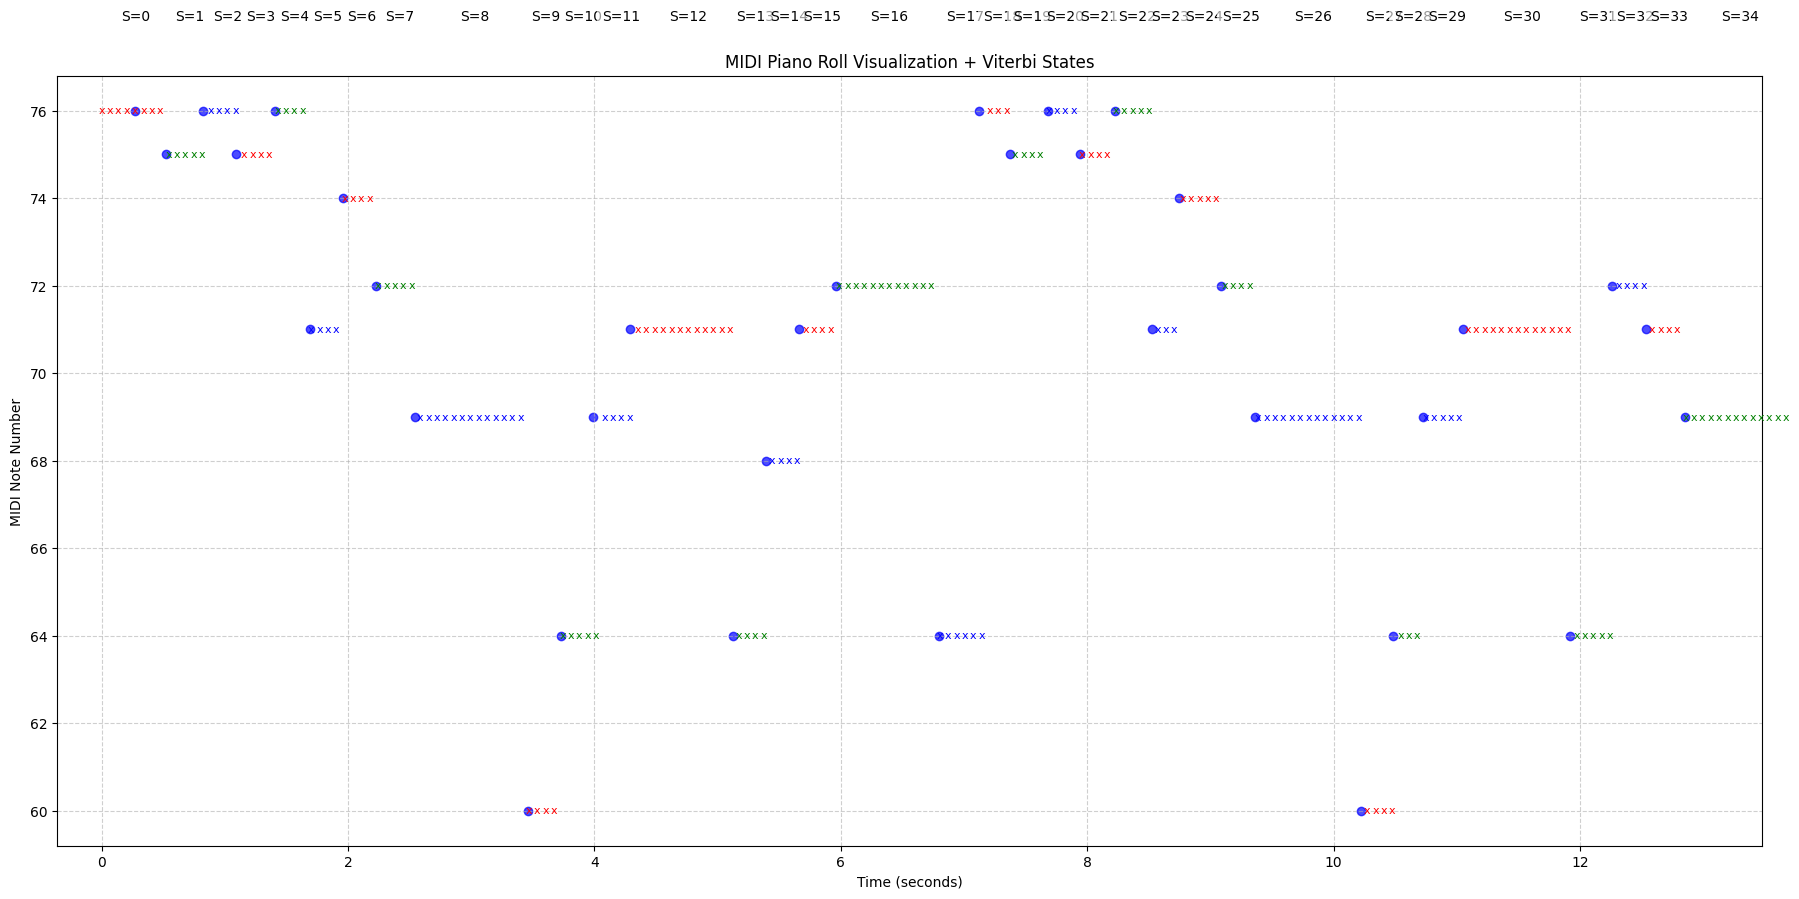

In [ ]:
plot_viterbi_output(midi, viterbi_output, (22,10), sample_rate, hmm_hop_size)